In [2]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tqdm

from astropy.io import fits as pyfits
from astropy import wcs
from astropy.table import Table, join, vstack
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from scipy.optimize import curve_fit

from random import choice

In [3]:
# Setting stuff
nan= float('nan')

pi= np.pi
e= np.e

plt.close('all')
c= 3.*10**8
h= 6.62*10**-34
k= 1.38*10**-23

Ken98= (4.5*10**-44)
Conversion2Chabrier=1.7 # Also Madau
Calzetti12= 2.8*10**-44
arrow = u'$\u2193$' 


Hal_cent = 6562.8
NIIr_cent = 6582.
NIIb_cent = 6548.

PATH='./'

# Getting the fuctions working 

In [4]:
def gaussian(x, a, b, c):
    val = a * np.exp(-(x - b)**2 / (2.*c**2))
    return val


def save_obj(obj, name ):
    with open(PATH + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    import pickle
    with open(PATH + name + '.pkl', 'rb') as f:
        return pickle.load(f, encoding='latin1')
    

In [25]:
def spec_gen_Halpha():
    # generating random properties
    z = np.random.uniform(1.4, 2.5)
    while  (z > 1.83) & (z < 1.94):
        z = np.random.uniform(1.4, 2.5)
    
    Nar_sig = np.random.uniform(200,700)/2.35   # Width of the narrow components
    Nar_fl = 10**np.random.uniform(-15.3, -12.3) # Flux of narrow Halpha
    NII_fl = np.random.uniform(0.1,1)*Nar_fl # Flux of [NII]
    
    
    Cont = np.random.uniform(0.01,0.2)*Nar_fl
    # Are we doing Type 1 or 2
    Type = choice([0,1])
    
    # Generating BLR proeprties

    BLR_fl = np.random.uniform(0.1,1)*Nar_fl*Type
    BLR_sig = np.random.uniform(4000,8000)/2.35  
    
    ###ll
    # Selecting Which band it was observed based on redshift
    Hw = np.linspace(1.42533, 1.86678, 2048)
    Kw = np.linspace(1.92543, 2.49972, 2048)
    
    if z<1.83:
        x=Hw
    elif z>1.94:
        x=Kw
    
    Nar_sig_wv = Nar_sig/3e5*(6562.8/1e4*(1+z))
    BLR_sig_wv = BLR_sig/3e5*(6562.8/1e4*(1+z))
    
    
    Nar_comp = gaussian(x, Nar_fl, Hal_cent/1e4*(1+z), Nar_sig_wv) + \
                gaussian(x, NII_fl, NIIr_cent/1e4*(1+z), Nar_sig_wv) + \
                gaussian(x, NII_fl/3, NIIb_cent/1e4*(1+z), Nar_sig_wv)
                
    BLR_comp = gaussian(x,BLR_fl, Hal_cent/1e4*(1+z), BLR_sig_wv)
    
    spec = Cont+BLR_comp + Nar_comp
    specn = spec + np.random.normal(0,np.random.uniform(0.1,0.3)*Nar_fl,2048)
                
    
    #plt.plot(x, spec, drawstyle='steps-mid')
    #plt.plot(x, BLR_comp)
    #plt.plot(x, Cont*np.ones_like(BLR_comp)+BLR_comp)
    
    Params = {'z':z}
    Params['Nar_fwhm'] = Nar_sig*2.35
    Params['BLR_fwhm'] = BLR_sig*2.35
    
    Params['BLR_fl'] = BLR_fl
    Params['Nar_fl'] = Nar_fl
    Params['NII_fl'] = NII_fl
    
    Params['Cont'] = Cont
    Params['Type'] = Type
    
    save = {'wave': x}
    save['flux'] = specn
    save['clean'] = spec
    save['Params'] = Params
    
    
    return save


def spec_gen_Halpha_gen2():
    # generating random properties
    
    z = np.random.uniform(1.4, 2.5)
    while (z > 1.83) and (z < 1.94):
        z = np.random.uniform(1.4, 2.5)
    
    ## 1/2.35 is a conversion between fullwidth half max and the gaussian sigma...
    
    Nar_sig = np.random.uniform(200,700)/2.35   # Width of the narrow components
    Nar_fl = 10**np.random.uniform(-15.3, -12.3) # Flux of narrow Halpha
    NII_fl = np.random.uniform(0.1,1)*Nar_fl # Flux of [NII]
    
    Nar_sig_wv = Nar_sig/3e5*(Hal_cent/1e4*(1+z))

    BLR_sig = np.random.uniform(4000,8000)/2.35  
    BLR_sig_wv = BLR_sig/3e5*(Hal_cent/1e4*(1+z))
        
    # Are we doing Type 1 or 2
    Type = choice([0,1])
    Outflow= choice([0,1])
    
    # Generating BLR properties
    # It goes up to two because why the hell not (bright quasars exist)
    if Type==1:
        BLR_fl = np.random.uniform(0.1,2)*Nar_fl    
    else:
        BLR_fl = 0
    
    if Outflow==0:
        Hal_out_fl = 0
        NII_out_fl = 0
    else:
        Hal_out_fl = np.random.uniform(0.05,0.2)*Nar_fl
        NII_out_fl = np.random.uniform(0.5,1.2)*Hal_out_fl
    
    
    Hal_out_sig = np.random.uniform(600,1000)/2.35 
    Hal_out_sig_wv = Hal_out_sig/3e5*(Hal_cent/1e4*(1+z))
    
    Hal_out_off = np.random.uniform(-600,200)
    Hal_out_off_wv = Hal_out_off/3e5*Hal_cent/1e4*(1+z)
    
    
    ###
    # Selecting which band it was observed based on redshift
    Hw = np.linspace(1.42533, 1.86678, 2048)
    Kw = np.linspace(1.92543, 2.49972, 2048)
    
    if z<1.83:
        x=Hw
    elif z>1.94:
        x=Kw
    
    # More complex contiuum - I kind of made it up until it looked like something I say before - Need to be more scientific
    Cont_lvl = np.random.uniform(0.01,0.2)*Nar_fl
    Cont = ( (x-Hal_cent/1e4*(1+z))*np.random.uniform(-0.1, 0.1))*Cont_lvl*20+ Cont_lvl
      
    
    Nar_comp = gaussian(x, Nar_fl, Hal_cent/1e4*(1+z), Nar_sig_wv) + \
                gaussian(x, NII_fl, NIIr_cent/1e4*(1+z), Nar_sig_wv) + \
                gaussian(x, NII_fl/3, NIIb_cent/1e4*(1+z), Nar_sig_wv)
                
    Out_comp = gaussian(x, Hal_out_fl, Hal_cent/1e4*(1+z)+Hal_out_off_wv, Hal_out_sig_wv) + \
                gaussian(x, NII_out_fl, NIIr_cent/1e4*(1+z)+Hal_out_off_wv, Hal_out_sig_wv) + \
                gaussian(x, NII_out_fl/3, NIIb_cent/1e4*(1+z)+Hal_out_off_wv, Hal_out_sig_wv)       
                
    BLR_vel_offset = np.random.uniform(-400,400)    
    BLR_wv_offset = BLR_vel_offset/3e5 * Hal_cent/1e4*(1+z)
    BLR_comp = gaussian(x,BLR_fl, Hal_cent/1e4*(1+z)+BLR_wv_offset, BLR_sig_wv)
    
    noise_level = np.random.uniform(0.05,0.3)*Nar_fl
    # Method to the madness: we assume there was a 3-10sigma detection, which means the nar_fl = (3-20)*noise.
    spec = Cont + BLR_comp + Nar_comp + Out_comp
    specn = spec  + np.random.normal(0,noise_level,2048)
                
    
    #plt.plot(x, spec, drawstyle='steps-mid')
    #plt.plot(x, BLR_comp)
    #plt.plot(x, BLR_comp+Out_comp)
    #plt.plot(x, Cont*np.ones_like(BLR_comp)+BLR_comp)
    
    Params = {'z':z}
    Params['Nar_fwhm'] = Nar_sig*2.35
    Params['BLR_fwhm'] = Hal_out_sig*2.35
    Params['Out_fwhm'] = BLR_sig*2.35
    
    Params['BLR_fl'] = BLR_fl
    Params['Nar_fl'] = Nar_fl
    Params['NII_fl'] = NII_fl
    
    Params['Hal_out_fl'] = Hal_out_fl
    Params['NII_out_fl'] = NII_out_fl
    
    Params['Out_off'] = Hal_out_off
    
    Params['Cont'] = Cont_lvl
    Params['Type'] = Type
    
    save = {'wave': x}
    save['flux'] = specn
    save['clean'] = spec
    save['Params'] = Params
    
    
    return save

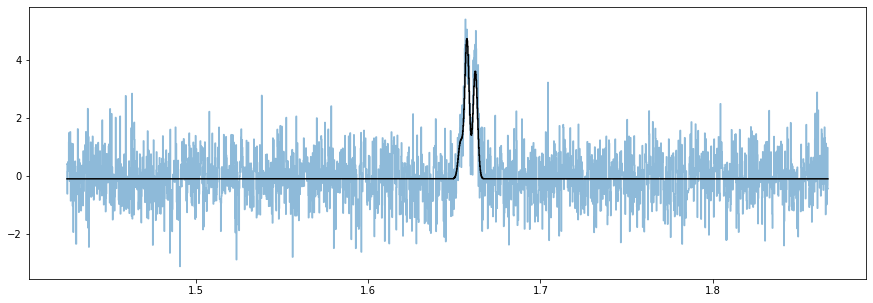

In [96]:
Spec_info = spec_gen_Halpha()
plt.figure(figsize=(15,5))
x = Spec_info['wave']
y0 = Spec_info['flux']
ym = np.mean(y0)
yv = np.sqrt(np.var(y0))
yd = (y0 - ym)/yv
yc = (Spec_info['clean'] - ym)/yv
plt.plot(x,yd, drawstyle='steps-mid',alpha=0.5)
plt.plot(x,yc, 'k-', drawstyle='steps-mid')

plt.show()

In [99]:
N = 100000

##
tosave = np.zeros((N,6152))
temparray = np.zeros(6152)

for i in tqdm.tqdm(range(N)):
    Spec_info = spec_gen_Halpha()
    temparray[0:2048] = Spec_info['wave']
    temparray[2048:4096] = Spec_info['flux']
    temparray[4096] = Spec_info['Params']['z']
    temparray[4097] = Spec_info['Params']['Nar_fwhm']
    temparray[4098] = Spec_info['Params']['BLR_fwhm']
    temparray[4099] = Spec_info['Params']['BLR_fl']
    temparray[4100] = Spec_info['Params']['Nar_fl']
    temparray[4101] = Spec_info['Params']['NII_fl']
    temparray[4102] = Spec_info['Params']['Cont']
    temparray[4103] = Spec_info['Params']['Type']
    temparray[4104:6152] = Spec_info['clean']
    tosave[i] = temparray

100%|██████████| 100000/100000 [00:26<00:00, 3763.20it/s]


In [ ]:
f = h5py.File('third_sample.hdf5','w')

dset = f.create_dataset("data", data=tosave)
dset.attrs['title'] = 'First fake dataset'
dset.attrs['descr'] = 'Here is where we can leave notes on how we made the data set...'
dset.attrs['columns'] = '0-2047: wavenumber, 2048-4095: flux, z, Nar_fwhm, BLR_fwhm, BLR_fl,Nar_fl,NII_fl,Cont,Type,4104-6152clean'
dset.attrs['N'] = N

f.close()